# Une approche du changement climatique à Lyon

## Préparation de l'environnement et ouverture du fichier de données

Importer d'abord le module `netcdf4` et `numpy`, attention les majuscules sont impératives pour le nom `netCDF4`. ces deux modules permettent de traiter  les fichiers multidimensionnels au format netCDF utilisés dans le monde de la météorologie et de l'océanographie principalement.

In [180]:
import netCDF4 as nc
import numpy as np
from datetime import datetime
from array import array
import sys

Importation des données de températures maximales depuis le fichier obtenu auprès du site [DRIAS](https://drias-prod.meteo.fr/okapi/accueil/okapiWebDrias/index.jsp) pour la région lyonnaise et intégration dans un fichier pour le traitement, puis affichage de la description du contenu, de la liste des variables.
L'exemple choisi ici a été réalisé avec une grille de 10 x 10 noeuds centrés sur la ville de Lyon, pour obtenir un jeu de données se reporter au manuel numérique réalisé par E. Le Jan et CArole Larose dans le cadre du projet "Climat et Météo Tremplin pour l'enseignement des sciences". Les deux affichages proposés permettent de vérifier les propriétés  du fichier obtenu ainsi que les variables qui pourront être utilisées. Ces affichages sont facultatifs et peuvent être commentés sans conséquence pour la suite.

In [181]:
tMaxLyon = nc.Dataset('/home/vidal/TremplinDesSciences/2019/ClimatLyon/tasmax_metro_CNRM_Aladin_rcp2.6_QT_RCP2.6_20060101-21001231.nc')
#print('Description des données issues du modèle : \n',tMaxLyon,'\n') 
print('Variables disponibles :',tMaxLyon.variables.keys(),'\n') # get all variable names

Variables disponibles : odict_keys(['i', 'j', 'lat', 'lon', 'tasmax', 'time', 'x', 'y']) 



## Liste des dimensions du système de données

À partir de la liste des variables obtenue ci-dessus on renomme les jeux de données de chacune des variables qui seront exploitées apour effectuer les calculs et contrôle de la taille des échantillons. Les affichages proposés permettent de contrôler que les paramètres présents sont effectivement ceux qui sont attendus.

In [184]:
#for dim in tMaxLyon.dimensions.items():
#    print(dim[1])
lyon_temp = tMaxLyon.variables['tasmax']  # variable temperature 
lyon_date = tMaxLyon.variables['time']  # variable temps
lyon_lat,lyon_lon = tMaxLyon.variables['lat'], tMaxLyon.variables['lon']  # latitude longitude
lyon_x,lyon_y = tMaxLyon.variables['x'], tMaxLyon.variables['y']  # coordonnées métriques
lyon_gridi,lyon_gridj = tMaxLyon.variables['i'], tMaxLyon.variables['j'] # coordonnées grille Aladin
print ('Variables \t  Forme \t\t Taille \t type :  \n')
for var in tMaxLyon.variables.keys() :
    print (var, '\t\t', tMaxLyon.variables[var].dimensions, '\t\t', 
           tMaxLyon.variables[var].shape, '\t', tMaxLyon.variables[var].dtype)
#print ('\n Unités : \n', lyon_temp.units, '\t', 
#      lyon_date.units, '\t',
#      lyon_lat.units, '\t', 
#      lyon_lon.units, '\t',
#      lyon_x.units, '\t', 
#      lyon_y.units, '\n')
#print(lyon_gridi[:])

Variables 	  Forme 		 Taille 	 type :  

i 		 ('i',) 		 (10,) 	 float64
j 		 ('j',) 		 (10,) 	 float64
lat 		 ('j', 'i') 		 (10, 10) 	 float32
lon 		 ('j', 'i') 		 (10, 10) 	 float32
tasmax 		 ('time', 'j', 'i') 		 (34698, 10, 10) 	 float32
time 		 ('time',) 		 (34698,) 	 float64
x 		 ('i',) 		 (10,) 	 int32
y 		 ('j',) 		 (10,) 	 int32


## Construction du jeu de données de sortie des moyennes en fonction de : année mois latitude longitude

Création du fichier de sortie au format netCDF où seront stockées les valeurs moyennes calculées pour chaque noeud

In [185]:
try: extractLyonYearMonth.close()  # par sécurité vérification qu'un fichier portant ce nom n'est pas déjà ouvert
except: pass
extractLyonTempYearMonth = nc.Dataset('tsmaxLyon-1.nc',mode='w',format='NETCDF4') 

Définition et affectation des variables où sont copiées les données conservées et où seront stockés les résultats des calculs. (La syntaxe du fichier netCDF reste à  vérifier). Les années seront calculées pendant le calcul principal, les affichages permettent de vérifier la validité des données utilisées.

In [186]:
data = []
years = []
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul',
            'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'total']
lenMonthA =[31,28,31,30,31,30,31,31,30,31,30,31]
lenMonthB =[31,29,31,30,31,30,31,31,30,31,30,31]
#startDate = date[0] + offset# 0 premier janvier; 90 -> 1er avril ; 212 1er aout
offset = 0
firstyear = int(nc.num2date(lyon_date[offset],lyon_date.units).strftime("%Y"))
lastyear = int(nc.num2date(lyon_date[-1],lyon_date.units).strftime("%Y"))
lenmonths = len(months)
lenyears = lastyear - firstyear + 1
lengridi = lyon_gridi.shape[0]
lengridj = lyon_gridj.shape[0]
print ("DateTime de départ  de l'étude : ", firstyear,
      "\nDateTime de fin  de l'étude : ", lastyear,
      "\nDurée de l'étude : ", lenyears, 'ans')
extractLyonTempYearMonth.createDimension('i', lengridi)     # latitude axis
gridi = lyon_gridi
extractLyonTempYearMonth.createDimension('j', lengridj)    # longitude axis
gridj = lyon_gridj
extractLyonTempYearMonth.createDimension('month', lenmonths)    # month axis
month = months
extractLyonTempYearMonth.createDimension('year', lenyears) # year axis

# Define two variables with the same names as dimensions,
# a conventional way to define "coordinate variables".
lat = extractLyonTempYearMonth.createVariable('lat', np.float32, ('j','i'))
lat.units = 'degrees_north'
lat.long_name = 'latitude'
lat = lyon_lat
lon = extractLyonTempYearMonth.createVariable('lon', np.float32, ('j','i',))
lon.units = 'degrees_east'
lon.long_name = 'longitude'
lon = lyon_lon
month = extractLyonTempYearMonth.createVariable('month', np.uint8, ('month',))
month.units = 'number'
month.long_name = 'month'
year = extractLyonTempYearMonth.createVariable('year', np.uint, ('year',))
year.units = 'date'
year.long_name = 'year'
# Define a 3D variable to hold the data
temp = extractLyonTempYearMonth.createVariable('temp',np.float64,('year','month','j','i')) # note: unlimited dimension is leftmost
temp.units = '°C' # degrees Kelvin
temp.standard_name = 'air_temperature' # this is a CF standard name
extractLyonTempYearMonth.title='Extrait TSMax par moyenne mensuelle'
#print(gridi[:],gridj[:])
#print(gridi.shape,gridj.shape)
#print(lat[2,:])

DateTime de départ  de l'étude :  2006 
DateTime de fin  de l'étude :  2100 
Durée de l'étude :  95 ans


## Calcul principal des moyennes par mois pour chaque noeud et toutes les années


In [187]:
iteri = offset
iterj = 0
iteriFirst = iteri
while iteri  < lyon_temp.shape[0] :      
    for iterj in  range(lenyears) :
        year[iterj] = (nc.num2date(lyon_date[iteri],lyon_date.units).strftime("%Y"))
#    print(nc.num2date(my_date[iteri],my_date.units), iteri, iterj)  # vérification du point de départ
        if (iterj % 4 == 2) :
            for i in range(len(lenMonthB)) :
                iteriLast = iteri+lenMonthB[i]
                temp[iterj,i,:,:] = np.mean(lyon_temp[iteri:iteriLast,:,:] - 273,axis=0) # moyenne du mois
                iteri = iteriLast
        else :
            for i in range(len(lenMonthA)) :
                iteriLast = iteri+lenMonthA[i]
                temp[iterj,i,:,:] = np.mean(lyon_temp[iteri:iteriLast,:,:] - 273,axis=0) # moyenne du mois
                iteri = iteriLast
        temp[iterj,len(lenMonthA),:,:] = np.mean(lyon_temp[iteriFirst:iteriLast,:,:] - 273,axis=0) # moyenne de l'année
        iteriFirst = iteriLast+1
#print(iteri)
#print('fin du traitement : ', nc.num2date(lyon_date[iteri-2],lyon_date.units)) # vérification de la fin d'année
    
#years = year[:].tolist()
#print ('years : \n', years)


Les affichages suivants permettent de vérifier  que les données obtenues correspondent au format attendu

In [188]:
#print('température moyenne année 2015 noeud 5 5 : \n', temp[9,:,5,5])
#print("température moyenne mois d'avril sur les 95 années noeud 8 4 : \n", temp[:,3,8,4])
#print("température moyenne année 2050 mois d'aout tous les  noeuds : \n", temp[45,7,:,:])

### Calculs pour UNE SEULE PÉriode de  `yearInterval` années

Calcul de la moyenne de températures du mois de `calcMonth` sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`

In [189]:
# Années
yearBegin = 2010
yearInterval = 30
calcMonth = 4
#  Grille i j
starti = 5
intervali = 4
startj = 2
intervalj = 4
# Variables de calcul
startYear = yearBegin - 2006
endYear = startYear + yearInterval
endi = starti + intervali
endj = startj + intervalj
loc_i = 2
loc_j = 3
locLon = lon[loc_j,loc_i]
locLat = lat[loc_j,loc_i]
locMonth = months[calcMonth]

                          
if not  (startYear >= 0) and (endYear <= lenyears) :
    print('starting year or finishing year out of bounds')
    sys.exit('giving up on year bounds')
#print(gridj[loc_j])
#print(gridi[loc_i])
#print(locLon)
#print(locLat)
#print(locMonth)
#print(startYear,':',endYear,',',calcMonth,',',startj,':',endj,',',starti,':',endi)
#print(temp.shape)
#print(np.mean(temp[startYear:endYear,calcMonth,startj:endj,starti:endi]))

    

#### Une valeur pour un mois donné
Calcul de la moyenne de températures du mois de `calcMonth` sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`

In [190]:
moyAreaInterval = np.mean(temp[startYear:endYear,calcMonth,startj:endj,starti:endi]) 
print(moyAreaInterval)

19.8438470184803


#### 13 valeurs (une par mois et année)
Calcul de la moyenne de températures annuelle et de tous les mois sur `yearInterval` années à partir de l'année `yearBegin` sur les noeuds allant de `(startj,starti)` de taille `(intervalj,intervali)`.  Les douze moyennes mensuelles sont suivies de la moyenne annuelle.

In [191]:
moyAreaInterval = [None] * lenmonths
moyAreaInterval[:] = np.mean(temp[startYear:endYear,:,startj:endj,starti:endi],axis=(0,2,3)) 
print(moyAreaInterval)
with open('moyMonth.txt', 'w') as file :
    for p in range(lenmonths) :
        file.write(months[p])
        file.write(';')
        file.write(str(moyAreaInterval[p]))
        file.write('\n')

[5.388181164224322, 7.991834558794896, 11.503244266907375, 15.604295363028845, 19.8438470184803, 22.459869209925333, 25.49642684459686, 27.22473424275716, 23.019419968128204, 16.802036740382512, 10.66239970823129, 7.089559948692719, 16.161257968346277]


In [194]:
import plotly 
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

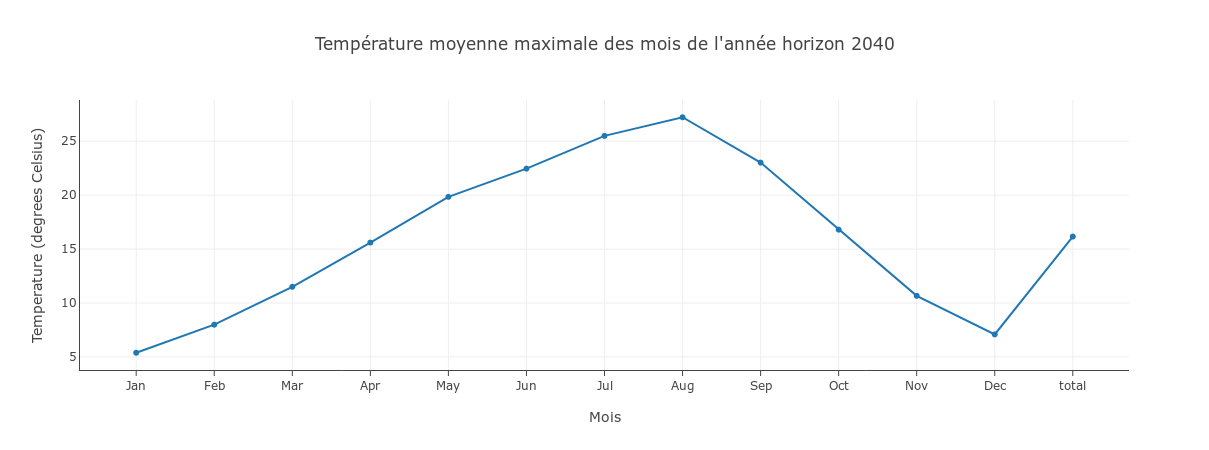

In [196]:
trace0 = go.Scatter(
    x = months[:],
    y = moyAreaInterval[:],
    name ='Avril 2040'
)

data = [trace0]

layout = dict (
           title = "Température moyenne maximale des mois de l'année horizon 2040",
           xaxis = dict(
                 title = 'Mois',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig, filename='basic-line')

#### n X n valeurs pour n² noeuds  pour 12 mois et année
Calcul de la moyenne de températures annuelle et de tous les mois sur `yearInterval` années à partir de l'année `yearBegin` sur chaque noeud allant de `(startj,starti)` de taille `(intervalj,intervali)`.  Les douze moyennes mensuelles sont suivies de la moyenne annuelle.

In [197]:
moyAreaInterval = np.zeros((lenmonths,intervalj,intervali))
moyAreaInterval[:] = np.mean(temp[startYear:endYear,:,startj:endj,starti:endi],axis=(0)) 
print(moyAreaInterval.shape)
#print(moyAreaInterval[:,0,0])
nbnoeuds = intervalj *intervali
data = [] * nbnoeuds
trace = [] * nbnoeuds

(13, 4, 4)


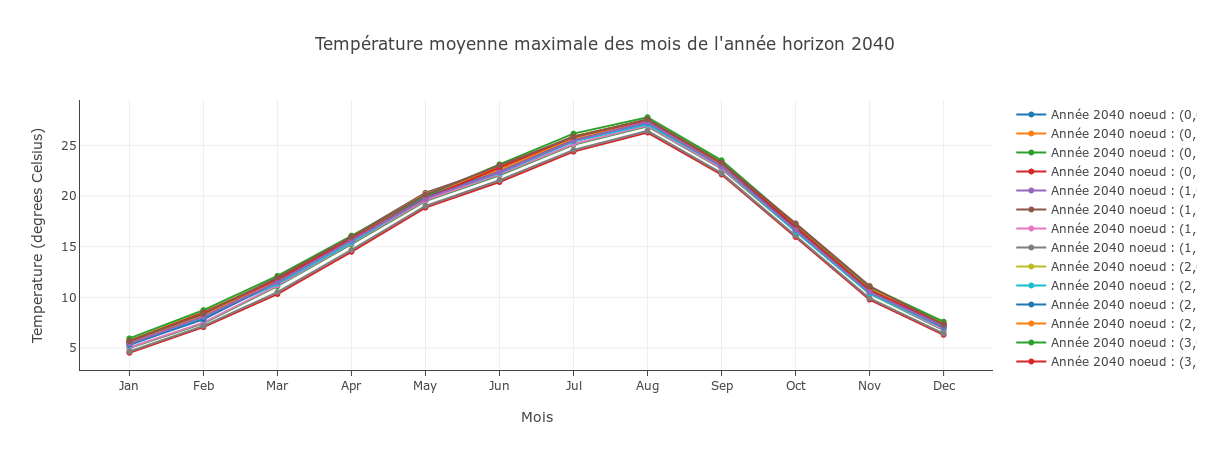

In [198]:
for p in range(intervalj) :
    for q in range(intervali) :
        order = p * intervalj + q
        trace = go.Scatter(
            x = months[0:12],
            y = moyAreaInterval[:,p,q],
            name ='Année 2040 noeud : (%s'%(str(p)+','+str(q)+')')
        )
        data.append(trace)

layout = dict (
           title = "Température moyenne maximale des mois de l'année horizon 2040",
           xaxis = dict(
                 title = 'Mois',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig, filename='basic-line')


### Calculs pour UNE SÉRIE DE  PÉRIODES de  `yearInterval` années

Calcul de la moyenne de températures des mois de `calcMonth` (il peut y en avoir un seul ou un choix), sur `yearInterval` années à partir de l'année `yearBegin` jusqu'à l'année `yearBegin + yearPeriod` sur les noeuds à partir de `(startj,starti)` de taille `(intervalj,intervali)`. La valeur touvée est affectée à la dernière année de la plage de calcul.

In [199]:
# ASéquence d'années pendant lesquelles les calculs sont effectués
yearBegin = 2010
yearInterval = 30
yearPeriod = 40
calcMonth = [4,5,6,7,8,9]
lencalcMonths = len(calcMonth)
#  Grille i j
starti = 5
intervali = 4
startj = 2
intervalj = 4
# Variables de calcul
startYear = yearBegin - 2006
endYear = startYear + yearInterval
#print(yearPeriodInterval)
endi = starti + intervali
endj = startj + intervalj
loc_i = 2
loc_j = 3
locLon = lon[loc_j,loc_i]
locLat = lat[loc_j,loc_i]

                          
if not  (startYear >= 0) and (endYear <= lenyears) :
    print('starting year or finishing year out of bounds')
    sys.exit('giving up on year bounds')
#print(gridj[loc_j])
#print(gridi[loc_i])
#print(locLon)
#print(locLat)
#print(locMonth)
#print(startYear,':',endYear,',',calcMonth,',',startj,':',endj,',',starti,':',endi)
#print(temp.shape)
#print(np.mean(temp[startYear:endYear,calcMonth,startj:endj,starti:endi]))

    

### Calcul pour n mois sur p périodes de q années pour la zone

Calcul de la moyenne des températures mensuelles sur `yearInterval` ans pendant une période de `yearPeriod` années successives pour une sélection de `calcMonth`  mois.

In [200]:
moyAreaInterval = np.zeros((lencalcMonths,yearPeriod))
for p in range(yearPeriod) :
    a = startYear + p
    b = endYear + p    
    moyAreaInterval[:,p] = np.mean(temp[a:b,calcMonth,startj:endj,starti:endi],axis=(0,2,3)) 
#print(moyAreaInterval)
firstPlotYear = startYear + yearInterval
lastPlotYear = firstPlotYear + yearPeriod
data = [] * lencalcMonths
trace = [] * lencalcMonths

Le diagramme ci-dessous  représente l'évolution sur `yearPeriod` années de la température dans la région Lyonnaise.

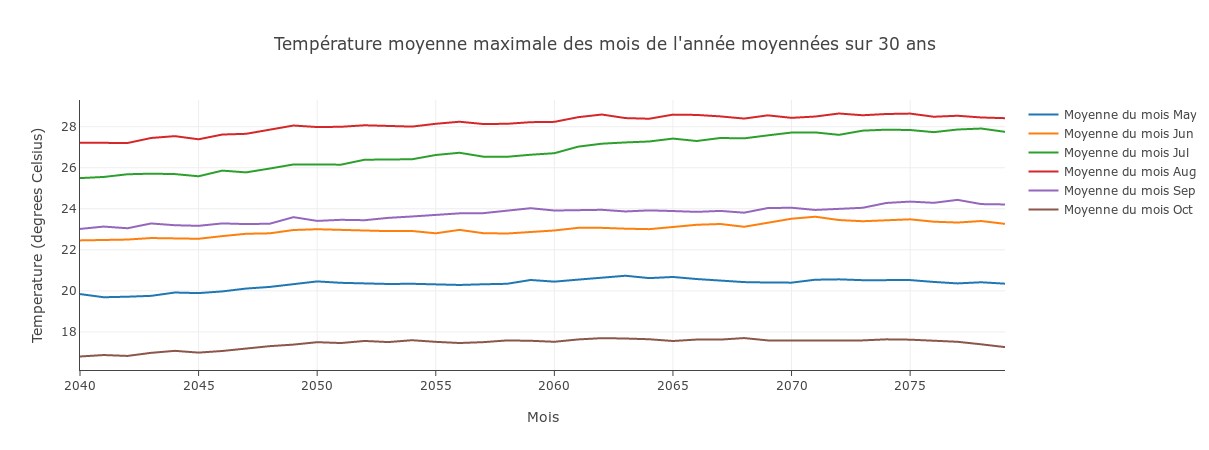

In [201]:
for q in range(lencalcMonths) :
    trace = go.Scatter(
        x = year[firstPlotYear:lastPlotYear],
        y = moyAreaInterval[q,:],
        name ='Moyenne du mois %s'%months[calcMonth[q]]
    )
    data.append(trace)

layout = dict (
           title = "Température moyenne maximale des mois de l'année moyennées sur 30 ans",
           xaxis = dict(
                 title = 'Mois',
                 showline=True,
                 showticklabels=True,
                 ticklen=5
             ),
             yaxis = dict(
                 title = 'Temperature (degrees Celsius)',
                 showline=True,
                 showticklabels=True
             ),         
)


fig = dict(data=data, layout=layout)

plotly.offline.iplot(fig, filename='basic-line')
